In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import sys
import numpy as np
import scipy.io
import platform
from math import *
import os
import glob
import datetime
import json
import ipdb
deb = ipdb.set_trace
opj = os.path.join

# MRI analysis imports
# --------------------
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter
import nibabel as nb


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
subject = 'sub-001'
preproc = 'fmriprep_dct'
slice_nb = 25
# fit_model = sys.argv[3]
start_time = datetime.datetime.now()

# Define analysis parameters
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
base_dir = analysis_info['base_dir']
nb_procs = 32

In [3]:
# Load data
data_file = "{base_dir}/pp_data/{sub}/func/{sub}_task-GazeCenterFS_{preproc}_avg.nii.gz".format(
                        base_dir = base_dir, sub = subject, preproc = preproc)
data_img = nb.load(data_file)
data = data_img.get_fdata()
data_var = np.var(data,axis=3)
mask = data_var!=0.0

In [4]:
slice_mask = mask[:, :, slice_nb].astype(bool)
num_vox = np.sum(slice_mask)
data_slice = data[:,:,slice_nb,:]
data_to_analyse = data_slice[slice_mask]

In [5]:
# determine voxel indices
y, x = np.meshgrid( np.arange(data.shape[1]),np.arange(data.shape[0]))
x_vox,y_vox = x[slice_mask],y[slice_mask]
vox_indices = [(xx,yy,slice_nb) for xx,yy in zip(x_vox,y_vox)]

In [6]:
# Create stimulus design (create in matlab - see others/make_visual_dm.m)
visual_dm_file = scipy.io.loadmat(opj(base_dir,'pp_data','visual_dm','GazeCenterFS_vd.mat'))
# visual_dm = visual_dm_file['stim']
visual_dm = visual_dm_file['stim'].transpose([1,0,2])

In [7]:
stimulus = PRFStimulus2D(screen_width_cm = analysis_info['screen_width'],
                         screen_height_cm = analysis_info['screen_height'],
                         screen_distance_cm = analysis_info['screen_distance'],
                         design_matrix = visual_dm,
                         TR = analysis_info['TR'])

In [8]:
gm = Iso2DGaussianModel(stimulus = stimulus)
grid_nr = 21
max_ecc_size = 15
sizes = max_ecc_size * np.linspace(0.25,1,grid_nr)**2
eccs = max_ecc_size * np.linspace(0.1,1,grid_nr)**2
polars = np.linspace(0, 2*np.pi, grid_nr)
ns = np.linspace(0.1,1,grid_nr)

gf = Iso2DGaussianFitter(data = data_to_analyse, model = gm, n_jobs = 10)
print('grid fit')
gf.grid_fit(ecc_grid = eccs, polar_grid = polars, size_grid = sizes, n_batches = 1000, pos_prfs_only = True)

grid fit


In [9]:
print('iterative fit')
gf.iterative_fit(rsq_threshold = 0.4, verbose = True)

iterative fit


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:   11.7s finished


In [10]:
np.nanmax(gf.iterative_search_params[:,5])

0.5742698576464261

In [34]:
# cssm = CSS_Iso2DGaussianModel(stimulus = stimulus)
# cssf = CSS_Iso2DGaussianFitter(data = data_to_analyse, model = cssm, n_jobs = 10, previous_gaussian_fitter = gf)
# starting_params = cssf.insert_new_model_params(cssf.iterative_search_params)
# cssf.iterative_fit(rsq_threshold = 0.3, verbose = True, starting_params = starting_params)

In [35]:
# for numvox in np.where(gf.gridsearch_r2>=0.4)[0]:
    
#     real_data = data_to_analyse[numvox].T
#     g_grid_params = gf.gridsearch_params[numvox]
#     g_grid_model_data = gm.return_prediction(g_grid_params[0],g_grid_params[1],g_grid_params[2],g_grid_params[3],g_grid_params[4]).T
#     g_iterative_params = gf.iterative_search_params[numvox]
#     g_iterative_model_data = gm.return_prediction(g_iterative_params[0],g_iterative_params[1],g_iterative_params[2],g_iterative_params[3],g_iterative_params[4]).T

#     c_iterative_params = cssf.iterative_search_params[numvox]
#     c_iterative_model_data = cssm.return_prediction(c_iterative_params[0],c_iterative_params[1],c_iterative_params[2],c_iterative_params[3],c_iterative_params[4],c_iterative_params[5]).T

#     plt.figure()
#     plt.plot(real_data,'+');

#     plt.plot(g_grid_model_data,'r');
#     plt.plot(g_iterative_model_data,'g');
#     plt.plot(c_iterative_model_data,'k');
#     axes = plt.gca()
#     axes.set_ylim([-4,3])
#     plt.text(0, -2, "grid g: x={:.2f} y={:.2f} size={:.2f} beta={:.2f} baseline={:.2f}".format(
#                                                                                g_grid_params[0],g_grid_params[1],
#                                                                                g_grid_params[2],g_grid_params[3],
#                                                                                g_grid_params[4]),color='r')
#     plt.text(0, -2.5, "iter g: x={:.2f} y={:.2f} size={:.2f} beta={:.2f} baseline={:.2f}".format(
#                                                                                g_iterative_params[0],g_iterative_params[1],
#                                                                                g_iterative_params[2],g_iterative_params[3],
#                                                                                g_iterative_params[4]),color='g')
#     plt.text(0, -3, "iter c: x={:.2f} y={:.2f} size={:.2f} beta={:.2f} baseline={:.2f}, n= {:.2f}".format(
#                                                                                c_iterative_params[0],c_iterative_params[1],
#                                                                                c_iterative_params[2],c_iterative_params[3],
#                                                                                c_iterative_params[4],c_iterative_params[5]),color='k')

In [36]:
# dogm = DoG_Iso2DGaussianModel(stimulus = stimulus)
# dogf = DoG_Iso2DGaussianFitter(data = data_to_analyse, model = cssm, n_jobs = 10, previous_gaussian_fitter = gf)
# starting_params = dogf.insert_new_model_params(gf.iterative_search_params)
# dogf.iterative_fit(rsq_threshold = 0.5, verbose = True, starting_params = starting_params)

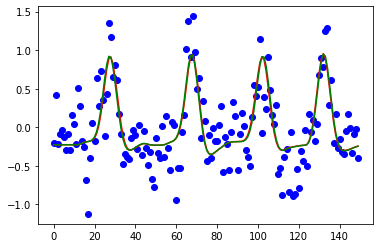

In [11]:
g_grid_params = gf.gridsearch_params[gf.gridsearch_r2==np.nanmax(gf.gridsearch_r2)][0]
g_grid_model_data = gm.return_prediction(g_grid_params[0],g_grid_params[1],g_grid_params[2],g_grid_params[3],g_grid_params[4],g_grid_params[5]).T
g_iterative_params = gf.iterative_search_params[gf.gridsearch_r2==np.nanmax(gf.gridsearch_r2)][0]
g_iterative_model_data = gm.return_prediction( g_iterative_params[0],g_iterative_params[1],g_iterative_params[2],g_iterative_params[3],g_iterative_params[4],g_iterative_params[5]).T

# c_iterative_params = cssf.iterative_search_params[gf.gridsearch_r2==np.nanmax(gf.gridsearch_r2)][0]
# c_iterative_model_data = cssm.return_prediction(c_iterative_params[0],c_iterative_params[1],c_iterative_params[2],c_iterative_params[3],c_iterative_params[4],c_iterative_params[5]).T

# d_iterative_params = dogf.iterative_search_params[gf.gridsearch_r2==np.nanmax(gf.gridsearch_r2)][0]
# d_iterative_model_data = dogm.return_prediction(d_iterative_params[0],d_iterative_params[1],d_iterative_params[2],d_iterative_params[3],d_iterative_params[4],d_iterative_params[5],d_iterative_params[6]).T

real_data = data_to_analyse[gf.gridsearch_r2==np.nanmax(gf.gridsearch_r2)].T

plt.plot(real_data,'ob');
plt.plot(g_grid_model_data,'r');
plt.plot(g_iterative_model_data,'g');
# plt.plot(c_iterative_model_data,'k');
# plt.plot(d_iterative_model_data);

In [15]:
gm.return_prediction(g_grid_params[0],g_grid_params[1],g_grid_params[2],g_grid_params[3],g_grid_params[4],g_grid_params[5]).shape

(1, 150)

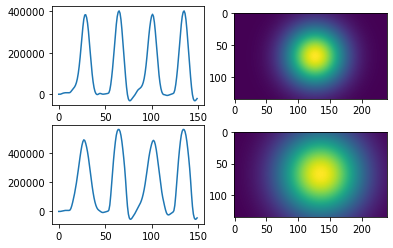

In [12]:
num_grid = 46;
ax1=plt.subplot(2, 2, 1)
ax1.plot(gm.predictions[num_grid,:]);

ax1=plt.subplot(2, 2, 2)
ax1.imshow(gm.grid_rfs[num_grid,:,:])


num_grid = 90;
ax1=plt.subplot(2, 2, 3)
ax1.plot(gm.predictions[num_grid,:]);
ax1=plt.subplot(2, 2, 4)
ax1.imshow(gm.grid_rfs[num_grid,:,:])

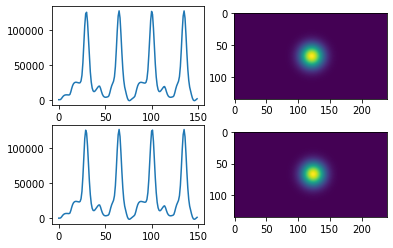

In [13]:
num_grid = 0;
ax1=plt.subplot(2, 2, 1)
ax1.plot(gm.predictions[num_grid,:]);
ax1=plt.subplot(2, 2, 2)
ax1.imshow(gm.grid_rfs[num_grid,:,:])
num_grid = 21;
ax1=plt.subplot(2, 2, 3)
ax1.plot(gm.predictions[num_grid,:]);
ax1=plt.subplot(2, 2, 4)
ax1.imshow(gm.grid_rfs[num_grid,:,:])

In [ ]:
gg.stimulus.convolved_design_matrix[:,:,:].shape

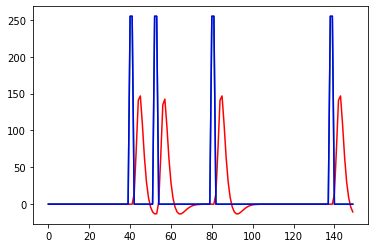

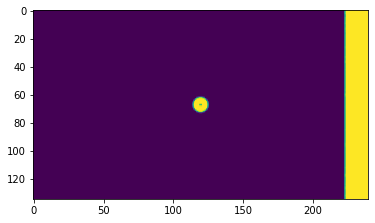

In [14]:
plt.figure()
x = 0
y = 0
plt.plot(gm.stimulus.convolved_design_matrix[x,y,:], 'r')
plt.plot(gm.stimulus.design_matrix[x,y,:],'g')
plt.plot(visual_dm[x,y,:],'b')

# show the plot
plt.show()
plt.imshow(visual_dm[:,:,11])

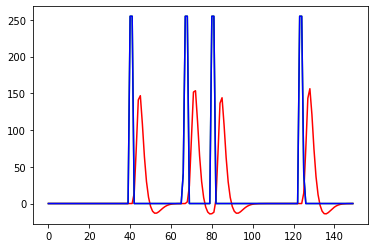

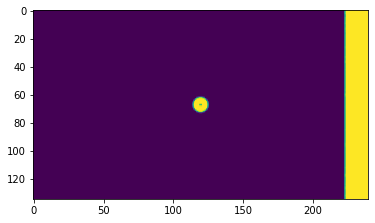

In [15]:
plt.figure()
x = 120
y = 0
plt.plot(gm.stimulus.convolved_design_matrix[x,y,:], 'r')
plt.plot(gm.stimulus.design_matrix[x,y,:],'g')
plt.plot(visual_dm[x,y,:],'b')

# show the plot
plt.show()
plt.imshow(visual_dm[:,:,11])

In [ ]:
plt.plot(data_to_analyse[0,:]);
plt.plot(data_to_analyse[3300,:]);

In [ ]:
.shape